In [1]:
#matplotlib inline
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
def get_data():
    df = pd.read_csv('ecommerce_data.csv')
    data = df.as_matrix()
    
    X = data[:, :-1] #extract data X
    Y = data[:, -1] #extract data Y
    
    # normalize columns 1 and 2
    X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()
    X[:,2] = (X[:,2] - X[:,2].mean()) / X[:,2].std()

    # create a new matrix X2 with the correct number of columns
    N, D = X.shape
    X2 = np.zeros((N, D+3))
    X2[:,0:(D-1)] = X[:,0:(D-1)] # non-categorical

    # one-hot
    for n in range(N):
        t = int(X[n,D-1])
        X2[n,t+D-1] = 1

    # method 2
    # Z = np.zeros((N, 4))
    # Z[np.arange(N), X[:,D-1].astype(np.int32)] = 1
    # # assign: X2[:,-4:] = Z
    # assert(np.abs(X2[:,-4:] - Z).sum() < 1e-10)

    return X2, Y

In [3]:
def get_binary_data():
    # return only the data from the first 2 classes
    X, Y = get_data()
    X2 = X[Y <= 1]
    Y2 = Y[Y <= 1]
    return X2, Y2

In [4]:
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [5]:
X, Y = get_data()
X, Y = shuffle(X, Y)
Y = Y.astype(np.int32)
M = 5
D = X.shape[1]
K = len(set(Y))

In [6]:
# create train and test sets
Xtrain = X[:-100]
Ytrain = Y[:-100]
Ytrain_ind = y2indicator(Ytrain, K)
Xtest = X[-100:]
Ytest = Y[-100:]
Ytest_ind = y2indicator(Ytest, K)

# randomly initialize weights
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

In [7]:
# make predictions
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    Z = np.tanh(X.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2), Z

def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

# calculate the accuracy
def classification_rate(Y, P):
    return np.mean(Y == P)

def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))


0 0.319190925566 0.333571940869
1000 0.0354462492261 0.0401387219437
2000 0.0256054792263 0.0361972797445
3000 0.0178261834112 0.0252155458827
4000 0.015326711908 0.0224150898146
5000 0.0141587784626 0.022014862138
6000 0.013395946918 0.0221272400463
7000 0.0128335938385 0.0225287028755
8000 0.012391232956 0.0230917047228
9000 0.0120272230188 0.0237261075418
Final train classification_rate: 0.98
Final test classification_rate: 0.95


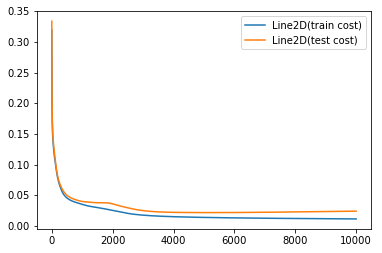

In [8]:
# train loop
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)

    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)

    # gradient descent
    W2 -= learning_rate*Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate*(pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain*Ztrain)
    W1 -= learning_rate*Xtrain.T.dot(dZ)
    b1 -= learning_rate*dZ.sum(axis=0)
    if i % 1000 == 0:
        print(i, ctrain, ctest)

print("Final train classification_rate:", classification_rate(Ytrain, predict(pYtrain)))
print("Final test classification_rate:", classification_rate(Ytest, predict(pYtest)))

legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.show()